In [2]:
# jupyter notebooks header --------------------------------------------------------------
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import sys
np.set_printoptions(linewidth=250, suppress=True)
np.set_printoptions(threshold=sys.maxsize)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
import utils.data_loaders
import utils.data_transforms
import utils.network_utils
from config import cfg
from models.encoder import Encoder
from models.decoder import Decoder
from models.refiner import Refiner
from models.merger import Merger
from models.classifier import Classifier
from matplotlib import pyplot as plt

In [21]:


IMG_SIZE = cfg.CONST.IMG_H, cfg.CONST.IMG_W
CROP_SIZE = cfg.CONST.CROP_IMG_H, cfg.CONST.CROP_IMG_W
train_transforms = utils.data_transforms.Compose([
    utils.data_transforms.RandomCrop(IMG_SIZE, CROP_SIZE),
    #utils.data_transforms.RandomBackground(cfg.TRAIN.RANDOM_BG_COLOR_RANGE),
    utils.data_transforms.ColorJitter(cfg.TRAIN.BRIGHTNESS, cfg.TRAIN.CONTRAST, cfg.TRAIN.SATURATION),
    utils.data_transforms.RandomNoise(cfg.TRAIN.NOISE_STD),
    utils.data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
    utils.data_transforms.RandomFlip(),
    utils.data_transforms.RandomPermuteRGB(),
    utils.data_transforms.ToTensor(),
])

#cfg.DATASET.CLASSES_TO_USE = None
cfg.DATASET.CLASSES_TO_USE = ['cabinet']
cfg.CONST.BATCH_SIZE = 8
cfg.CONST.N_VIEWS_RENDERING = 1
train_dataset_loader = utils.data_loaders.DATASET_LOADER_MAPPING[cfg.DATASET.TRAIN_DATASET](cfg)


train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_loader.get_dataset(utils.data_loaders.DatasetType.TRAIN,
                                             cfg.CONST.N_VIEWS_RENDERING, train_transforms, classes_filter = cfg.DATASET.CLASSES_TO_USE),
    batch_size=cfg.CONST.BATCH_SIZE,
    num_workers=cfg.TRAIN.NUM_WORKER,
    pin_memory=True,
    shuffle=True,
    drop_last=True)

num_classes = 13
encoder = Encoder(cfg)
decoder = Decoder(cfg)
refiner = Refiner(cfg)
merger = Merger(cfg)
classifier = Classifier(cfg, num_classes)



[INFO] 2020-03-03 19:52:06.408364 Loading cache of Taxonomy[ID=02933112, Name=cabinet, Partition=train]
[INFO] 2020-03-03 19:52:06.425436 Complete collecting files of the dataset. Total files: 1100.


In [ ]:
print(utils.network_utils.count_parameters(encoder))
print(utils.network_utils.count_parameters(decoder))
print(utils.network_utils.count_parameters(refiner))
print(utils.network_utils.count_parameters(classifier))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['02933112', '02933112', '02933112', '02933112', '02933112', '02933112', '02933112', '02933112']
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2]])
torch.Size([8, 4])
(224, 224, 3)


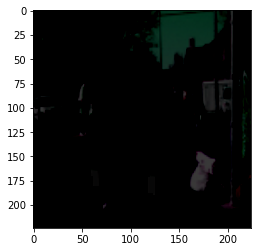

In [23]:
for (taxonomy_names, sample_names, rendering_images,
                        ground_truth_volumes, ground_truth_class_labels) in train_data_loader:
    print(taxonomy_names) 
    print(ground_truth_class_labels)
    ground_truth_class_labels = ground_truth_class_labels.repeat(4,1).T
    print(ground_truth_class_labels)
    print(ground_truth_class_labels.shape)
    test_img = rendering_images[0][0].cpu().numpy()
    test_img = np.transpose(test_img, (1,2,0))
    plt.imshow(test_img)
    print(test_img.shape)
    break

In [ ]:


encoder.eval()
decoder.eval()
refiner.eval()
merger.eval()
classifier.eval()
ce_loss = torch.nn.CrossEntropyLoss() # for classification

gt_labels = None
class_pred = None

for (taxonomy_names, sample_names, rendering_images,
        ground_truth_volumes, ground_truth_class_labels) in train_data_loader:
    
    with torch.no_grad():
        image_features = encoder(rendering_images)
        class_predictions = classifier(image_features)
        class_predictions = class_predictions.reshape(-1,num_classes)
        ground_truth_class_labels = ground_truth_class_labels.repeat(cfg.CONST.N_VIEWS_RENDERING,1).T
        ground_truth_class_labels = ground_truth_class_labels.reshape(-1)
        classification_loss = ce_loss(class_predictions, ground_truth_class_labels) 
        class_pred = class_predictions
        gt_labels = ground_truth_class_labels
    
    break

In [ ]:
accuracy = (torch.argmax(class_pred, 1) == torch.argmax(class_pred, 1)).sum() / gt_labels.shape[0]
accuracy = (gt_labels == torch.argmax(class_pred, 1)).sum() / gt_labels.shape[0]
print(accuracy)